## Obstacle closeness penalty
$(1+|\gamma_{\theta}\theta_{i}|)^{-1}(\gamma_{x}max(x_i, \epsilon_x)^{2})^{-1}$


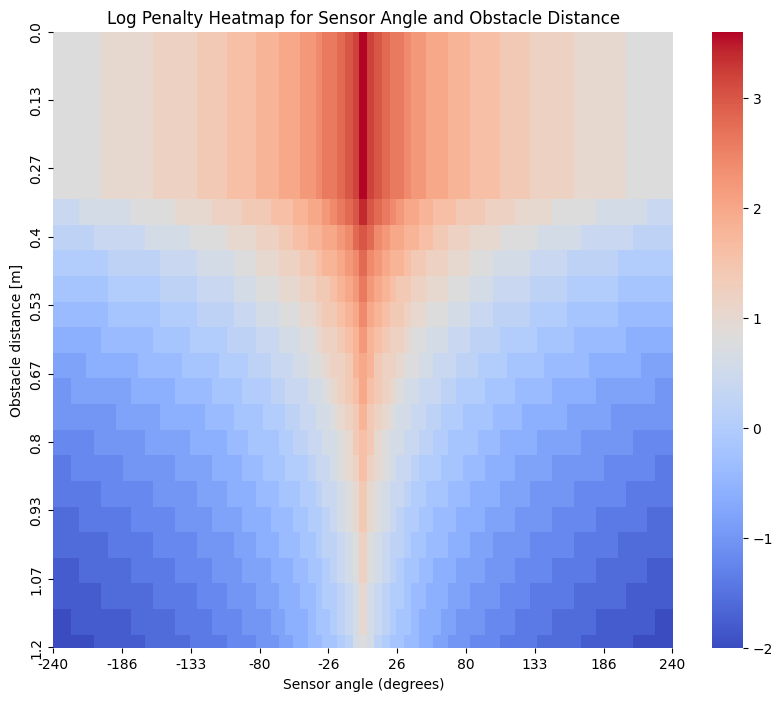

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import math
from factory_env.envs.parameters import env_param

def discrete_output_reward_final(X, Y, gamma_theta, gamma_x, eps, output_step):
    """
    Calculate the continuous reward and then discretize the output.
    """
    # Calculate the continuous reward
    penalties = np.log((1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, eps)**2) ** -1)

    # Discretize the output
    discrete_penalties = np.round(penalties / output_step) * output_step
    return discrete_penalties

def discrete_output_reward_state(X, Y, gamma_theta, gamma_x, eps, res_angles, res_distances):
    """
    Calculate the continuous reward and then discretize the output.
    """
    # Calculate the continuous reward
    X = np.round(X / res_angles) * res_angles
    Y = np.round(Y / res_distances) * res_distances
    discrete_penalties = np.log((1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, eps)**2) ** -1)
    # discrete_penalties = (1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, eps)**2) ** -1

    discrete_penalties = np.round(discrete_penalties / 0.2) * 0.2
    return discrete_penalties

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

param = env_param()
pi = math.pi
# Constants
gamma_theta = 4.0  # You need to set this value according to your paper
gamma_x = 0.3 # You need to set this value according to your paper 0.005
eps = 0.3
# let's assume we have sensor angles in range from -180 to 180 degrees
sensor_angles = np.linspace(-4*pi/3, 4*pi/3, 721) # start, end, number of points
sensor_angles_deg = np.rad2deg(sensor_angles) # convert to degrees

# and we have obstacle distances in range from 0 to 50 units (meters, feet, etc.)
obstacle_distances = np.linspace(0, param.sensor_param.Sr *1.2, 1000)

# create a 2D grid
X, Y = np.meshgrid(sensor_angles, obstacle_distances)

# calculate penalties based on the given function
# penalties = np.log((1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, eps)**2) ** -1)
# penalties = (1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, 0.1)**2) ** -1
# penalties = discrete_output_reward_final(X, Y, gamma_theta, gamma_x, eps, output_step=0.2)
penalties = discrete_output_reward_state(X, Y, gamma_theta, gamma_x, eps, res_angles=0.1, res_distances=0.05)
# Discretize penalties
num_bins = 20  # Number of bins you want
penalties_discrete = np.digitize(penalties, np.linspace(np.min(penalties), np.max(penalties), num_bins))

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(penalties_discrete, cmap='coolwarm', ax=ax, xticklabels=100, yticklabels=100)
sns.heatmap(penalties, cmap='coolwarm', ax=ax, xticklabels=100, yticklabels=100)
ax.set_xlabel('Sensor angle (degrees)')
ax.set_ylabel('Obstacle distance [m]')
ax.set_title('Log Penalty Heatmap for Sensor Angle and Obstacle Distance')
# Format tick labels

# Set up ticks
num_ticks = 10
x_ticks = np.linspace(start=-240, stop=240, num=num_ticks)  # adjust these parameters for your specific case
x_tick_indices = [find_nearest(sensor_angles_deg, tick) for tick in x_ticks]
ax.set_xticks(x_tick_indices)
ax.set_xticklabels([int(x) for x in x_ticks])

# Similarly for y_ticks (adjust the parameters for your specific case)
y_ticks = np.linspace(start=0, stop=1.2, num=num_ticks)  
y_tick_indices = [find_nearest(obstacle_distances, tick) for tick in y_ticks]
ax.set_yticks(y_tick_indices)
ax.set_yticklabels([round(y,2) for y in y_ticks])

plt.show()


In [3]:
r_oa = 0.0
r_oa -= (1 + np.abs(gamma_theta * np.pi)) ** -1 * (gamma_x * 5**2) ** -1
print(r_oa)

-0.004113204451696847


## Cross-error reward

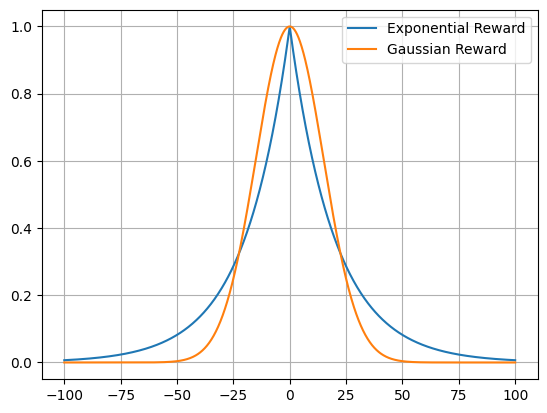

In [4]:
from scipy.stats import norm
gamma_e = 0.05
e = np.linspace(-100, 100, 1000) # start, end, number of points
exp_reward = np.exp(-gamma_e * np.abs(e))

mu = 0
sigma = 15
sigma_adj = np.sqrt(2 * np.pi) * sigma

# PDF (Probability Density Function)
pdf = norm.pdf(e, mu, sigma)

# Adjust the PDF so that its peak is 1
gaussian_reward = pdf / norm.pdf(mu, mu, sigma)

plt.plot(e, exp_reward)
plt.plot(e, gaussian_reward)
plt.grid()
plt.legend(['Exponential Reward', 'Gaussian Reward'])

-0.999 3.0


[Text(0, 90, '-180'),
 Text(0, 150, '-140'),
 Text(0, 210, '-100'),
 Text(0, 270, '-60'),
 Text(0, 330, '-20'),
 Text(0, 390, '20'),
 Text(0, 450, '60'),
 Text(0, 510, '100'),
 Text(0, 570, '140'),
 Text(0, 630, '180')]

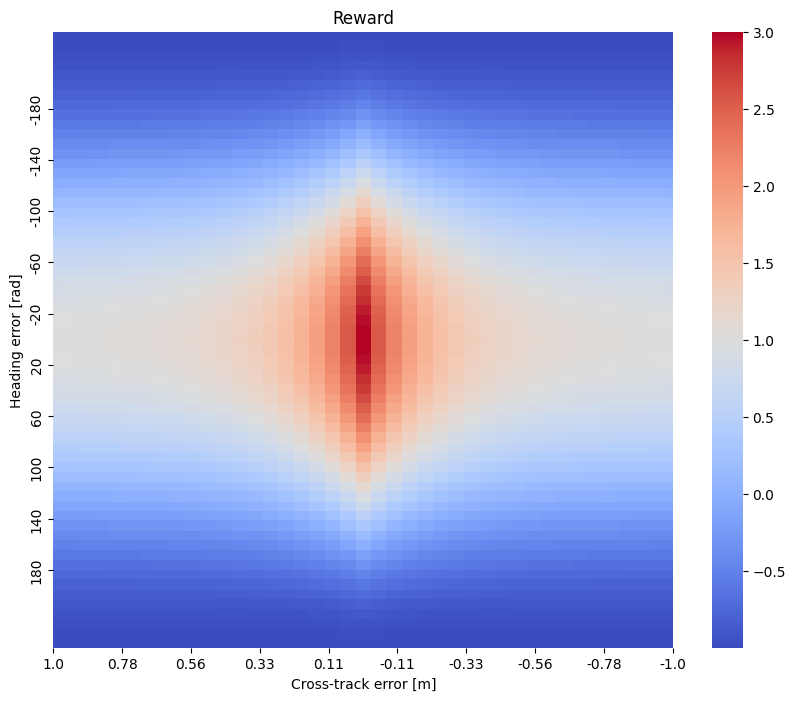

In [12]:

def discrete_output_reward(X, Y, gamma_e, output_step):
    """
    Calculate the continuous reward and then discretize the output.
    """
    # Calculate the continuous reward
    continuous_reward = -1 + (1 * np.cos(Y) + 1) * (np.exp(-gamma_e * np.abs(X)) + 1)

    # Discretize the output
    discrete_reward = np.round(continuous_reward / output_step) * output_step
    return discrete_reward

def discrete_output_reward(X, Y, gamma_e, res_e, res_c):
    """
    Calculate the continuous reward and then discretize the output.
    """
    # Calculate the continuous reward
    xd = np.round(X / res_e) * res_e
    yd = np.round(Y / res_c) * res_c
    discrete_reward = -1 + (1 * np.cos(yd) + 1) * (np.exp(-gamma_e * np.abs(xd)) + 1)
    # Discretize the output
    # discrete_reward = np.round(continuous_reward / output_step) * output_step
    return np.round(discrete_reward,3)

output_step = 0.1
res_e = 0.05
res_c = 0.1

e_min = 1.0
e_max = -e_min
gamma_e = 5.0 # 0.5
e = np.linspace(e_min, e_max, 1000) # start, end, number of points
heading_error = np.linspace(-pi, pi, 721) # start, end, number of points
X, Y = np.meshgrid(e, heading_error)
# reward = -1 + (1 * np.cos(Y)+1) * (np.exp(-gamma_e * np.abs(X)) + 1)
# reward = discrete_output_reward(X, Y, gamma_e, output_step)
reward =  discrete_output_reward(X, Y, gamma_e, res_e, res_c)
print(reward.min(), reward.max())
# reward = np.log(reward)
# Discretize penalties
min_reward = np.min(reward)
max_reward= np.max(reward)
bins = np.linspace(min_reward, max_reward, num_bins)
num_bins = 30  # Number of bins you want
reward_discrete = np.digitize(reward, bins, num_bins)/10.0

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(reward, cmap='coolwarm', ax=ax, xticklabels=100, yticklabels=100)
# sns.heatmap(reward_discrete, cmap='coolwarm', ax=ax, xticklabels=100, yticklabels=100)
ax.set_xlabel('Cross-track error [m]')
ax.set_ylabel('Heading error [rad]')
ax.set_title('Reward')

# Set up ticks
num_ticks = 10
x_ticks = np.linspace(start=e_min, stop=e_max, num=num_ticks)  # adjust these parameters for your specific case
x_tick_indices = [find_nearest(e, tick) for tick in x_ticks]
ax.set_xticks(x_tick_indices)
ax.set_xticklabels([round(x, 2) for x in x_ticks])

# Similarly for y_ticks (adjust the parameters for your specific case)
y_ticks = np.linspace(start=-180, stop=180, num=num_ticks)  
y_tick_indices = [find_nearest(sensor_angles_deg, tick) for tick in y_ticks]
ax.set_yticks(y_tick_indices)
ax.set_yticklabels([int(y) for y in y_ticks])

In [6]:
step_penalty_rate = 1000
current_step = 700
step_penalty = step_penalty_rate * (np.exp((current_step - 200) / 334.87) - 1) if current_step > 300 else 0
print(step_penalty)

3450.946329419508


In [7]:
closest_point_yaw_angle = np.deg2rad(30)
R = np.array([[np.cos(closest_point_yaw_angle), -np.sin(closest_point_yaw_angle)],
                      [np.sin(closest_point_yaw_angle), np.cos(closest_point_yaw_angle)]])
point = np.array([0, 1])
closest_point_to_trajectory = np.array([1, 1])
eta = R.T @ (point - closest_point_to_trajectory) # eta = [s, x]->[along-track error, cross-track error]
print(f"eta: [s, x] = {eta}") 

eta: [s, x] = [-0.866  0.5  ]


In [8]:
gamma_theta = 4.0  # You need to set this value according to your paper
gamma_x = 2.0 # You need to set this value according to your paper 0.005
eps = 0.3

def discrete_output_reward_state(X, Y, gamma_theta, gamma_x, res_angles, res_distances):
    """
    Calculate the continuous reward and then discretize the output.
    """
    # Calculate the continuous reward
    xd = np.round(X / res_angles) * res_angles
    yd = np.round(Y / res_distances) * res_distances
    discrete_penalties = np.log((1 + np.abs(gamma_theta * X)) ** -1 * (gamma_x * np.maximum(Y, 0.1)**2) ** -1)
    # Discretize the output
    # discrete_reward = np.round(continuous_reward / output_step) * output_step
    return np.round(discrete_penalties,3)



193.3425773466587


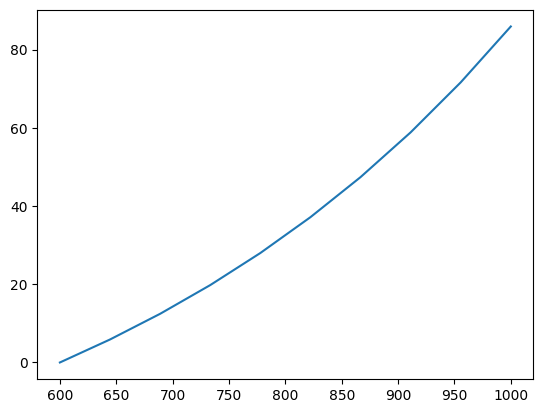

In [9]:
import numpy as np
r_arrived = 200
step_penalty_rate = 50
ep_step = 650

scaling_factor = 12/6
adj_p = 400*scaling_factor
step_penalty = step_penalty_rate * (np.exp((ep_step - 600) / 400) - 1) if ep_step > 300 else 0
rend = r_arrived - step_penalty
print(rend)

ep_step = np.linspace(600, 1000, 10)
step_penalty = step_penalty_rate * (np.exp((ep_step - 600) / 400) - 1)
plt.plot(ep_step, step_penalty)

In [10]:
step_penalty_rate = 10
Lp = 6
Lp_std = 6
arrive_reward_adj = 400 * (Lp/Lp_std)
optimal_total_steps = int(Lp / self.params.atr_param.atr_linear_vel_max / self.params.atr_param.dt)


step_penalty = step_penalty_rate * (np.exp((ep_step - optimal_total_steps) / arrive_reward_adj) - 1)

NameError: name 'self' is not defined